# Exploration 7
---
## Naver Movie Review Sentiment Analysis 😎🎬
---


1. Problem Definition
2. EDA
    1. Data Imbalance
3. Korean morpheme Analyzers
     1. konlpy
        - mecab
        - kkma
        - okt
        - komoran
        - hannanum
     2. kakao api
        - khaiii
     3. soynlp
        - soyspacing
4. Data Loader
5. Modeling
6. Word2Vec
7. Result & Summary

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings(action='ignore')
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [2]:
print(train_data.shape, test_data.shape)

(150000, 3) (50000, 3)


## EDA
    


train, test 데이터의 label 분포를 확인한다. 만약 분포가 불균형 하다면 오버샘플링을 활용해

부족한 데이터를 추가하는 방법을 고려할 수 있다. 이 데이터의 경우 label 분포는 균형을 이루고 있다.


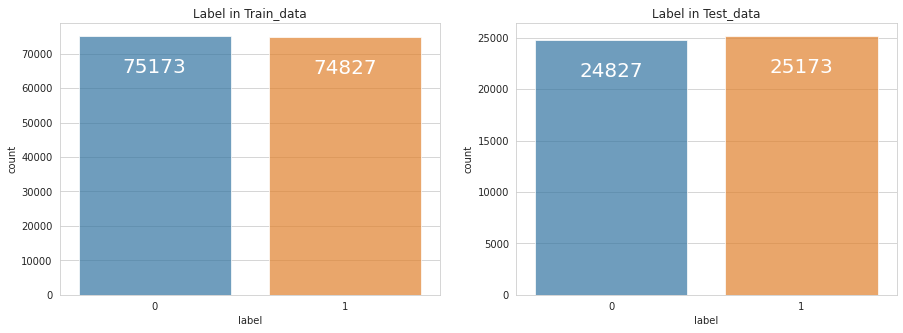

In [3]:
import seaborn as sns

plt.figure(figsize=(15,5))
sns.set_style('whitegrid')

data_dict = {
    "Label in Train_data" : train_data,
    "Label in Test_data" :  test_data
}

count=1
for title, data in data_dict.items():
    if count == 3:
        break
    plt.subplot(1,2, count)
    ax = sns.countplot(x='label', data=data, alpha=0.7)
    for p in ax.patches:    
        ax.annotate(f'\n{int(p.get_height())}', (p.get_x()+0.4, p.get_height()), ha='center', va='top', color='white', size=20)
    plt.title('{}'.format(title))
    plt.xlabel('label')
    plt.ylabel('count')
    count += 1
    
plt.show()

## 한국어 형태소 분석기

---

이기창님의 저서 '한국어 임베딩'을 참고하여 오픈소스 형태소 분석기 7가지를 사용하여 토큰화, 품사 태깅 결과를 확인하였다.

보다 자세한 내용은 링크를 클릭하여 각 형태소분석기가 가진 특징을 확인할 수 있다.

konlpy 라이브러리 내 형태소분석기 
- [Mecab](https://konlpy-ko.readthedocs.io/ko/v0.4.3/morph/)
- [Okt](https://konlpy-ko.readthedocs.io/ko/v0.4.3/morph/)
- [Komoran](https://konlpy-ko.readthedocs.io/ko/v0.4.3/morph/)
- [Hannanum](https://konlpy-ko.readthedocs.io/ko/v0.4.3/morph/)
- [KKma](https://konlpy-ko.readthedocs.io/ko/v0.4.3/morph/)

---
카카오에서 개발한 형태소분석기로 국립언어원이 구축한 세종코퍼스를 이용해 CNN모델을 적용해 학습하였음
- [Khaiii](https://github.com/kakao/khaiii)

---
#### 비지도 학습 기반 형태소 분석
위의 지도 학습 방법은 언어 전문가들이 직접 형태소 경계나 품사 정보를 모델에 가르쳐줘서 학습된 모델들이다.
이와달리 비지도 학습 기법들은 데이터의 패턴을 모델 스스로 학습하게 함으로써 형태소를 분석하는 방법이다.
데이터에 자주 등장하는 단어들을 형태소로 인식한다.

- [soynlp](https://github.com/lovit/soynlp) : 
    - [soyspacing](https://github.com/lovit/soyspacing) : 비지도학습으로 학습된 모델을 이용하여 띄어쓰기 적용
    
[품사태깅비교표](https://docs.google.com/spreadsheets/d/1OGAjUvalBuX-oZvZ_-9tEfYD2gQe7hTGsgUpiiBSXI8/edit#gid=0)

In [4]:
# 데이터 조작을 위해 사본을 저장
train_data_copy = train_data.copy()

In [5]:
# Mecab 은전한닢 분석기 
from konlpy.tag import Mecab
mecab_tokenizer = Mecab()

mecab_df = pd.DataFrame(columns=['Original Review', 'After Tokenization', 'Pos Tagging'])

for review in train_data_copy['document'][:10].values:
    mecab_df=mecab_df.append({'Original Review' : review,
                              'After Tokenization' : mecab_tokenizer.morphs(review),
                              'Pos Tagging' : mecab_tokenizer.pos(review)},
                              ignore_index=True)

mecab_df

,Original Review,After Tokenization,Pos Tagging
0,아 더빙.. 진짜 짜증나네요 목소리,"[아, 더, 빙, ., ., 진짜, 짜증, 나, 네요, 목소리]","[(아, IC), (더, MAG), (빙, MAG), (., SF), (., SY)..."
1,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,"[흠, ., .., 포스터, 보고, 초딩, 영화, 줄, ., ..., 오버, 연기,...","[(흠, IC), (., SF), (.., SY), (포스터, NNP), (보고, ..."
2,너무재밓었다그래서보는것을추천한다,"[너무, 재, 밓었다그래서보는것을추천한다]","[(너무, MAG), (재, XPN), (밓었다그래서보는것을추천한다, UNKNOWN)]"
3,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,"[교도소, 이야기, 구먼, ., ., 솔직히, 재미, 는, 없, 다, ., ., 평...","[(교도소, NNG), (이야기, NNG), (구먼, VCP+EF), (., SF)..."
4,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,"[사이몬페그, 의, 익살, 스런, 연기, 가, 돋보였, 던, 영화, !, 스파이더맨...","[(사이몬페그, NNP), (의, JKG), (익살, NNG), (스런, XSA+E..."
5,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.,"[막, 걸음마, 뗀, 3, 세, 부터, 초등, 학교, 1, 학년, 생, 인, 8, ...","[(막, MAJ), (걸음마, NNG), (뗀, VV+ETM), (3, SN), (..."
6,원작의 긴장감을 제대로 살려내지못했다.,"[원작, 의, 긴장감, 을, 제대로, 살려, 내, 지, 못했, 다, .]","[(원작, NNG), (의, JKG), (긴장감, NNG), (을, JKO), (제..."
7,별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단...,"[별, 반개, 도, 아깝, 다, 욕, 나온다, 이응경, 길용우, 연기, 생활, 이,...","[(별, MM), (반개, NNG), (도, JX), (아깝, VA), (다, EC..."
8,액션이 없는데도 재미 있는 몇안되는 영화,"[액션, 이, 없, 는데, 도, 재미, 있, 는, 몇, 안, 되, 는, 영화]","[(액션, NNG), (이, JKS), (없, VA), (는데, EC), (도, J..."
9,왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?,"[왜, 케, 평점, 이, 낮, 은, 건데, ?, 꽤, 볼, 만한데, ., ., 헐리...","[(왜, MAG), (케, XSA+EC), (평점, NNG), (이, JKS), (..."


In [6]:
# Okt 분석기 
from konlpy.tag import Okt
okt_tokenizer = Okt()

okt_df = pd.DataFrame(columns=['Original Review', 'After Tokenization', 'Pos Tagging'])

for review in train_data_copy['document'][:10].values:
    okt_df=okt_df.append({'Original Review' : review,
                              'After Tokenization' : okt_tokenizer.morphs(review),
                              'Pos Tagging' : okt_tokenizer.pos(review)},
                              ignore_index=True)

okt_df

,Original Review,After Tokenization,Pos Tagging
0,아 더빙.. 진짜 짜증나네요 목소리,"[아, 더빙, .., 진짜, 짜증나네요, 목소리]","[(아, Exclamation), (더빙, Noun), (.., Punctuatio..."
1,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,"[흠, ..., 포스터, 보고, 초딩, 영화, 줄, ...., 오버, 연기, 조차,...","[(흠, Noun), (..., Punctuation), (포스터, Noun), (..."
2,너무재밓었다그래서보는것을추천한다,"[너, 무재, 밓었, 다그, 래서, 보는것을, 추천, 한, 다]","[(너, Modifier), (무재, Noun), (밓었, Noun), (다그, N..."
3,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,"[교도소, 이야기, 구먼, .., 솔직히, 재미, 는, 없다, .., 평점, 조정]","[(교도소, Noun), (이야기, Noun), (구먼, Noun), (.., Pu..."
4,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,"[사이, 몬페, 그, 의, 익살스런, 연기, 가, 돋보였던, 영화, !, 스파이더맨...","[(사이, Modifier), (몬페, Noun), (그, Determiner), ..."
5,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.,"[막, 걸음, 마, 뗀, 3, 세, 부터, 초등학교, 1, 학년, 생인, 8, 살용...","[(막, Noun), (걸음, Noun), (마, Noun), (뗀, Verb), ..."
6,원작의 긴장감을 제대로 살려내지못했다.,"[원작, 의, 긴장감, 을, 제대로, 살려내지못, 했다, .]","[(원작, Noun), (의, Josa), (긴장감, Noun), (을, Josa)..."
7,별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단...,"[별, 반개, 도, 아깝다, 욕, 나온다, 이응경, 길용우, 연, 기, 생활, 이,...","[(별, Noun), (반개, Noun), (도, Josa), (아깝다, Adjec..."
8,액션이 없는데도 재미 있는 몇안되는 영화,"[액션, 이, 없는데도, 재미, 있는, 몇, 안되는, 영화]","[(액션, Noun), (이, Josa), (없는데도, Adjective), (재미..."
9,왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?,"[왜케, 평점, 이, 낮은건데, ?, 꽤, 볼, 만, 한, 데, .., 헐리우드, ...","[(왜케, Noun), (평점, Noun), (이, Josa), (낮은건데, Adj..."


In [7]:
# komoran 분석기 
from konlpy.tag import Komoran
komoran_tokenizer = Komoran()

komoran_df = pd.DataFrame(columns=['Original Review', 'After Tokenization', 'Pos Tagging'])

for review in train_data_copy['document'][:10].values:
    komoran_df=komoran_df.append({'Original Review' : review,
                              'After Tokenization' : komoran_tokenizer.morphs(review),
                              'Pos Tagging' : komoran_tokenizer.pos(review)},
                              ignore_index=True)
komoran_df

,Original Review,After Tokenization,Pos Tagging
0,아 더빙.. 진짜 짜증나네요 목소리,"[아, 더빙, ., ., 진짜, 짜증, 나, 네요, 목소리]","[(아, IC), (더빙, NNP), (., SF), (., SF), (진짜, MA..."
1,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,"[흠, ..., 포스터, 보고, 초딩, 영화, 줄, ...., 오버, 연기, 조차,...","[(흠, IC), (..., SE), (포스터, NNP), (보고, JKB), (초..."
2,너무재밓었다그래서보는것을추천한다,[너무재밓었다그래서보는것을추천한다],"[(너무재밓었다그래서보는것을추천한다, NA)]"
3,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,"[교도소, 이야기, 이, 구먼, .., 솔직히, 재미, 는, 없, 다, ., ., ...","[(교도소, NNP), (이야기, NNG), (이, VCP), (구먼, EC), (..."
4,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,"[사이몬페그의, 익살, 스럽, ㄴ, 연기, 가, 돋보이, 었, 던, 영화, !, 스...","[(사이몬페그의, NA), (익살, NNG), (스럽, XSA), (ㄴ, ETM),..."
5,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.,"[막, 걸음마, 떼, ㄴ, 3, 세, 부터, 초등학교, 1, 학년, 생, 이, ㄴ,...","[(막, MAG), (걸음마, NNG), (떼, VV), (ㄴ, ETM), (3, ..."
6,원작의 긴장감을 제대로 살려내지못했다.,"[원작, 의, 긴장감, 을, 제대로, 살리, 어, 내, 지, 못하, 았, 다, .]","[(원작, NNP), (의, JKG), (긴장감, NNG), (을, JKO), (제..."
7,별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단...,"[별, 반개, 도, 아깝, 다, 욕, 나오, ㄴ다, 이응경, 길용우, 연기, 생활,...","[(별, MM), (반개, NNG), (도, JX), (아깝, VA), (다, EC..."
8,액션이 없는데도 재미 있는 몇안되는 영화,"[액션, 이, 없, 는데, 도, 재미, 있, 는, 몇, 안, 되, 는, 영화]","[(액션, NNP), (이, JKS), (없, VA), (는데, EC), (도, J..."
9,왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?,"[왜, 하, 게, 평점, 이, 낮, 은, 것, ㄴ데, ?, 꽤, 보, ㄹ, 만, 하...","[(왜, MAG), (하, XSV), (게, EC), (평점, NNG), (이, J..."


In [8]:
# komoran 분석기 
from konlpy.tag import Komoran
komoran_tokenizer = Komoran()

komoran_df = pd.DataFrame(columns=['Original Review', 'After Tokenization', 'Pos Tagging'])

for review in train_data_copy['document'][:10].values:
    komoran_df=komoran_df.append({'Original Review' : review,
                              'After Tokenization' : komoran_tokenizer.morphs(review),
                              'Pos Tagging' : komoran_tokenizer.pos(review)},
                              ignore_index=True)
komoran_df

,Original Review,After Tokenization,Pos Tagging
0,아 더빙.. 진짜 짜증나네요 목소리,"[아, 더빙, ., ., 진짜, 짜증, 나, 네요, 목소리]","[(아, IC), (더빙, NNP), (., SF), (., SF), (진짜, MA..."
1,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,"[흠, ..., 포스터, 보고, 초딩, 영화, 줄, ...., 오버, 연기, 조차,...","[(흠, IC), (..., SE), (포스터, NNP), (보고, JKB), (초..."
2,너무재밓었다그래서보는것을추천한다,[너무재밓었다그래서보는것을추천한다],"[(너무재밓었다그래서보는것을추천한다, NA)]"
3,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,"[교도소, 이야기, 이, 구먼, .., 솔직히, 재미, 는, 없, 다, ., ., ...","[(교도소, NNP), (이야기, NNG), (이, VCP), (구먼, EC), (..."
4,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,"[사이몬페그의, 익살, 스럽, ㄴ, 연기, 가, 돋보이, 었, 던, 영화, !, 스...","[(사이몬페그의, NA), (익살, NNG), (스럽, XSA), (ㄴ, ETM),..."
5,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.,"[막, 걸음마, 떼, ㄴ, 3, 세, 부터, 초등학교, 1, 학년, 생, 이, ㄴ,...","[(막, MAG), (걸음마, NNG), (떼, VV), (ㄴ, ETM), (3, ..."
6,원작의 긴장감을 제대로 살려내지못했다.,"[원작, 의, 긴장감, 을, 제대로, 살리, 어, 내, 지, 못하, 았, 다, .]","[(원작, NNP), (의, JKG), (긴장감, NNG), (을, JKO), (제..."
7,별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단...,"[별, 반개, 도, 아깝, 다, 욕, 나오, ㄴ다, 이응경, 길용우, 연기, 생활,...","[(별, MM), (반개, NNG), (도, JX), (아깝, VA), (다, EC..."
8,액션이 없는데도 재미 있는 몇안되는 영화,"[액션, 이, 없, 는데, 도, 재미, 있, 는, 몇, 안, 되, 는, 영화]","[(액션, NNP), (이, JKS), (없, VA), (는데, EC), (도, J..."
9,왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?,"[왜, 하, 게, 평점, 이, 낮, 은, 것, ㄴ데, ?, 꽤, 보, ㄹ, 만, 하...","[(왜, MAG), (하, XSV), (게, EC), (평점, NNG), (이, J..."


In [9]:
# Hannanum 분석기 
from konlpy.tag import Hannanum
hannanum_tokenizer = Hannanum()

hannanum_df = pd.DataFrame(columns=['Original Review', 'After Tokenization', 'Pos Tagging'])

for review in train_data_copy['document'][:10].values:
    hannanum_df=hannanum_df.append({'Original Review' : review,
                              'After Tokenization' : hannanum_tokenizer.morphs(review),
                              'Pos Tagging' : hannanum_tokenizer.pos(review)},
                              ignore_index=True)
hannanum_df

,Original Review,After Tokenization,Pos Tagging
0,아 더빙.. 진짜 짜증나네요 목소리,"[아, 더빙, .., 진짜, 짜증나, 네, 요, 목소리]","[(아, I), (더빙, N), (.., S), (진짜, N), (짜증나, P), ..."
1,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,"[흠, ., .., 포스터보고, 초딩영화줄, ...., 오버연기, 조차, 가볍, 지...","[(흠, N), (., S), (.., S), (포스터보고, N), (초딩영화줄, ..."
2,너무재밓었다그래서보는것을추천한다,[너무재밓었다그래서보는것을추천한다],"[(너무재밓었다그래서보는것을추천한다, N)]"
3,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,"[교도소, 이야기구먼, .., 솔직히, 재미, 는, 없, 다, .., 평점, 조정]","[(교도소, N), (이야기구먼, N), (.., S), (솔직히, M), (재미,..."
4,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,"[사이몬페그, 의, 익살, 스런, 연기, 가, 돋보이, 었던, 영화, !, 스파이더...","[(사이몬페그, N), (의, J), (익살, N), (스런, J), (연기, N)..."
5,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.,"[막, 걸음마, 떼, ㄴ, 3세, 부터, 초등학교, 1학년생, 이, ㄴ, 8살용영화...","[(막, M), (걸음마, N), (떼, P), (ㄴ, E), (3세, N), (부..."
6,원작의 긴장감을 제대로 살려내지못했다.,"[원작, 의, 긴장감, 을, 제대로, 살리, 어, 내, 지, 못하, 었다, .]","[(원작, N), (의, J), (긴장감, N), (을, J), (제대로, M), ..."
7,별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단...,"[별, 반개, 도, 아깝, 다, 욕나온다, 이응경, 길용우, 연기생활이몇년, 이, ...","[(별, M), (반개, N), (도, J), (아깝, P), (다, E), (욕나..."
8,액션이 없는데도 재미 있는 몇안되는 영화,"[액션, 이, 없, 는데, 도, 재미, 있, 는, 몇안되, 는, 영화]","[(액션, N), (이, J), (없, P), (는데, E), (도, J), (재미..."
9,왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?,"[왜케, 평점, 이, 낮, 은, 것, 이, ㄴ데, ?, 꽤, 보, ㄹ, 만, 하, ...","[(왜케, N), (평점, N), (이, J), (낮, P), (은, E), (것,..."


In [10]:
# KKma 분석기 
from konlpy.tag import Kkma
kkma_tokenizer = Kkma()

kkma_df = pd.DataFrame(columns=['Original Review', 'After Tokenization', 'Pos Tagging'])

for review in train_data_copy['document'][:10].values:
    kkma_df=kkma_df.append({'Original Review' : review,
                              'After Tokenization' : kkma_tokenizer.morphs(review),
                              'Pos Tagging' : kkma_tokenizer.pos(review)},
                              ignore_index=True)
kkma_df

,Original Review,After Tokenization,Pos Tagging
0,아 더빙.. 진짜 짜증나네요 목소리,"[아, 아, 더빙, .., 진짜, 짜증나, 네요, 목소리]","[(아, VV), (아, ECS), (더빙, NNG), (.., SW), (진짜, ..."
1,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,"[흠, ..., 포스터, 보고, 초, 딩, 영화, 줄, ...., 오버, 연기, 조...","[(흠, NNG), (..., SE), (포스터, NNG), (보고, NNG), (..."
2,너무재밓었다그래서보는것을추천한다,"[너무, 재, 밓, 어, 었, 다, 그래서, 보, 는, 것, 을, 추천, 하, ㄴ다]","[(너무, MAG), (재, NNG), (밓, UN), (어, VV), (었, EP..."
3,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,"[교도소, 이야기, 구, 멀, ㄴ, .., 솔직히, 재미, 는, 없, 다, .., ...","[(교도소, NNG), (이야기, NNG), (구, XSN), (멀, VA), (ㄴ..."
4,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,"[사이몬페그, 의, 익살, 스럽, ㄴ, 연기, 가, 돋보이, 었, 더, ㄴ, 영화,...","[(사이몬페그, UN), (의, JKG), (익살, NNG), (스럽, XSA), ..."
5,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.,"[막, 걸음마, 떼, ㄴ, 3, 세, 부터, 초등학교, 1, 학년, 생인, 8, 살...","[(막, MAG), (걸음마, NNG), (떼, VV), (ㄴ, ETD), (3, ..."
6,원작의 긴장감을 제대로 살려내지못했다.,"[원작, 의, 긴장감, 을, 제대로, 살리, 어, 내, 지, 못하, 었, 다, .]","[(원작, NNG), (의, JKG), (긴장감, NNG), (을, JKO), (제..."
7,별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단...,"[별, 반개, 도, 아깝, 다, 욕, 나오, ㄴ다, 이응, 경, 길, 용, 우, 연...","[(별, NNG), (반개, NNG), (도, JX), (아깝, VA), (다, E..."
8,액션이 없는데도 재미 있는 몇안되는 영화,"[액션, 이, 없, 는데, 도, 재미, 있, 는, 몇, 안, 되, 는, 영화]","[(액션, NNG), (이, JKS), (없, VA), (는데, ECD), (도, ..."
9,왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?,"[왜케, 평점, 이, 낮, 은, 것, 이, ㄴ데, ?, 꽤, 보, ㄹ, 만하, ㄴ데...","[(왜케, UN), (평점, NNG), (이, JKS), (낮, VA), (은, E..."


### KhaiiiApi 설치방법

---
[github](https://github.com/kakao/khaiii/wiki/%EB%B9%8C%EB%93%9C-%EB%B0%8F-%EC%84%A4%EC%B9%98) / [blog](https://blockchainstudy.tistory.com/57)

In [11]:
#KhaiiiApi 형태소분석기
from khaiii import KhaiiiApi
khaiii_tokenizer = KhaiiiApi()

khaiii_df = pd.DataFrame(columns=['Original Review', 'After Tokenization', 'Pos Tagging'])

for review in train_data_copy['document'][:10].values:
    data = khaiii_tokenizer.analyze(review)
    tokens = [] # tokenization
    pos = [] # pos tagging
    
    for word in data:
        tokens.extend([str(m).split("/")[0] for m in word.morphs])
        pos.extend([str(m) for m in word.morphs])
        
    khaiii_df=khaiii_df.append({'Original Review' : review,
                              'After Tokenization' : tokens,
                              'Pos Tagging' : pos},
                              ignore_index=True)
khaiii_df

,Original Review,After Tokenization,Pos Tagging
0,아 더빙.. 진짜 짜증나네요 목소리,"[아, 더, 빙, .., 진짜, 짜증, 나네, 요, 목소리]","[아/IC, 더/ZV, 빙/MAG, ../SF, 진짜/MAG, 짜증/NNG, 나네/..."
1,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,"[흠, ., .., 포, 스터, 보, 고, 초딩, 영화줄, ...., 오버, 연기,...","[흠/IC, ./SF, ../SE, 포/NNP, 스터/NNG, 보/VV, 고/EC,..."
2,너무재밓었다그래서보는것을추천한다,"[너무, 재, 밓, 었, 다, 그래, 서, 보, 는, 것, 을, 추천, 하, ㄴ다]","[너무/MAG, 재/NNG, 밓/SH, 었/EP, 다/EC, 그래/MAJ, 서/EC..."
3,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,"[교도소, 이야기, 이, 구, 멀, ㄴ, ., ., 솔직히, 재미, 는, 없, 다,...","[교도소/NNG, 이야기/NNG, 이/VCP, 구/EC, 멀/VA, ㄴ/ETM, ...."
4,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,"[사, 이몬페그, 의, 익살, 스럽, ㄴ, 연기, 가, 돋보이, 었, 던, 영화, ...","[사/NNG, 이몬페그/NNP, 의/JKG, 익살/NNG, 스럽/XSA, ㄴ/ETM..."
5,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.,"[막, 걸음마, 떼, ㄴ, 3, 세, 부터, 초등학교, 1, 학년, 생, 이, ㄴ,...","[막/MAG, 걸음마/NNG, 떼/VV, ㄴ/ETM, 3/SN, 세/NNB, 부터/..."
6,원작의 긴장감을 제대로 살려내지못했다.,"[원작, 의, 긴장감, 을, 제대로, 살리, 어, 내, 지, 못하, 였, 다, .]","[원작/NNG, 의/JKG, 긴장감/NNG, 을/JKO, 제대로/MAG, 살리/VV..."
7,별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단...,"[별, 반개, 도, 아깝, 다, 욕나오, ㄴ다, 이응경, 길용우, 연기, 생활, 이...","[별/MM, 반개/NNG, 도/JX, 아깝/VA, 다/EC, 욕나오/VV, ㄴ다/E..."
8,액션이 없는데도 재미 있는 몇안되는 영화,"[액션, 이, 없, 는데, 도, 재미, 있, 는, 몇, 안, 되, 는, 영화]","[액션/NNG, 이/JKS, 없/VA, 는데/EC, 도/JX, 재미/NNG, 있/V..."
9,왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?,"[왜, 케, 평점, 이, 낮, 은, 이, 건데, ?, 꽤, 보, ㄹ, 만, 하, ㄴ...","[왜/MAG, 케/NNG, 평점/NNG, 이/JKS, 낮/VA, 은/ETM, 이/V..."


### soynlp

---
soynlp는 비지도 학습 방법으로 모델 학습이 필요하므로 많은 텍스트 데이터를 확보하기 위해 

train의 150,000개, test의 50,000개 리뷰를 합한 200,000개 데이터 중에서 결측값, 중복 데이터를 제외한 나머지 데이터를 학습에 적용시킨다.

In [12]:
total_text = pd.concat((train_data, test_data))
total_text

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
49995,4608761,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
49996,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO,0
49997,9072549,그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다,0
49998,5802125,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,0


In [13]:
# 전처리
total_text.drop_duplicates(subset=['document'], inplace=True)
total_text = total_text.dropna(how = 'any')

In [14]:
# 텍스트 데이터를 저장
total_text['document'].to_csv(path_or_buf='/aiffel/aiffel/sentiment_classification/data/total_text.txt', index=False, header='document')

In [15]:
# soynlp 단어 점수 학습
from soynlp.word import WordExtractor

model_name = '/aiffel/aiffel/sentiment_classification/data/soyword_train.model'

sentences = [sent.strip() for sent in list(total_text.document.values)]

word_extractor = WordExtractor(min_frequency=100,
    min_cohesion_forward=0.05, 
    min_right_branching_entropy=0.0
)

word_extractor.train(sentences)
word_extractor.save(model_name)

training was done. used memory 2.243 Gbse memory 2.045 Gb


In [16]:
# soynlp 형태소 분석
import math
from soynlp.word import WordExtractor
from soynlp.tokenizer import LTokenizer

word_extractor.load(model_name)
scores = word_extractor.word_scores()
scores = {
    key : (scores[key].cohesion_forward * math.exp(scores[key].right_branching_entropy)) for key in scores.keys()}
soynlp_tokenizer = LTokenizer(scores=scores)

soynlp_df = pd.DataFrame(columns=['Original Review', 'After Tokenization'])

for review in train_data_copy['document'][:10].values:
    soynlp_df=soynlp_df.append({'Original Review' : review,
                              'After Tokenization' : soynlp_tokenizer.tokenize(review)},
                              ignore_index=True)
soynlp_df

all cohesion probabilities was computed. # words = 6096
all branching entropies was computed # words = 122528
all accessor variety was computed # words = 122528


,Original Review,After Tokenization
0,아 더빙.. 진짜 짜증나네요 목소리,"[아, 더빙, .., 진짜, 짜증, 나네요, 목소리]"
1,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,"[흠.., .포스터보고, 초딩, 영화줄....오버연기조차, 가볍, 지, 않구나]"
2,너무재밓었다그래서보는것을추천한다,"[너무, 재밓었다그래서보는것을추천한다]"
3,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,"[교도소, 이야기, 구먼, .., 솔직히, 재미, 는, 없다., .평점, 조정]"
4,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,"[사이, 몬페그의, 익살스런, 연기, 가, 돋보, 였던, 영화, !스파이더맨에서, ..."
5,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.,"[막, 걸음마, 뗀, 3세부터, 초등학교, 1학년생인, 8살용영화.ㅋㅋㅋ...별반개..."
6,원작의 긴장감을 제대로 살려내지못했다.,"[원작의, 긴장감, 을, 제대로, 살려, 내지못했다.]"
7,별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단...,"[별, 반개도, 아깝다, 욕나, 온다, 이응경, 길용우, 연기, 생활이몇년인지..정..."
8,액션이 없는데도 재미 있는 몇안되는 영화,"[액션, 이, 없는, 데도, 재미, 있는, 몇안되는, 영화]"
9,왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?,"[왜케, 평점, 이, 낮은, 건데?, 꽤, 볼만한, 데.., 헐리우드, 식, 화려,..."


### soyspacing 

---
200,000개의 텍스트 데이터를 학습한 모델로 띄어쓰기를 적용 할 수 있다.

corrected_review = spacing_model.correct(review)[0]  # correct() 함수로 띄어쓰기 적용

In [17]:
# !pip install soyspacing

In [18]:
from soyspacing.countbase import CountSpace

corpus_fname = '/aiffel/aiffel/sentiment_classification/data/total_text.txt'
model_name = '/aiffel/aiffel/sentiment_classification/data/space-correct_train.model'

spacing_model = CountSpace()
spacing_model.train(corpus_fname)
spacing_model.save_model(model_name, json_format=False)

all tags length = 617463 --> 130180, (num_doc = 194543))

In [19]:
spacing_model.load_model(model_name, json_format=False)

soynlp_df = pd.DataFrame(columns=['Original Review', 'After Spcing Review', 'After Tokenization'])
for review in train_data_copy['document'][:15].values:
    corrected_review = spacing_model.correct(review)[0]
    soynlp_df=soynlp_df.append({'Original Review' : review,
                                'After Spcing Review' : corrected_review,
                              'After Tokenization' : soynlp_tokenizer.tokenize(corrected_review)},
                              ignore_index=True)
soynlp_df

,Original Review,After Spcing Review,After Tokenization
0,아 더빙.. 진짜 짜증나네요 목소리,아 더빙.. 진짜 짜증나네요 목소리,"[아, 더빙, .., 진짜, 짜증, 나네요, 목소리]"
1,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,"[흠.., .포스터보고, 초딩, 영화줄....오버연기조차, 가볍, 지, 않구나]"
2,너무재밓었다그래서보는것을추천한다,너무 재밓었다그래서 보는것을 추천한다,"[너무, 재밓었다그래서, 보는, 것을, 추천, 한다]"
3,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,교도소 이야기구먼 .. 솔직히 재미는 없다..평점 조정,"[교도소, 이야기, 구먼, .., 솔직히, 재미, 는, 없다., .평점, 조정]"
4,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,"[사이, 몬페그의, 익살스런, 연기, 가, 돋보, 였던, 영화, !스파이더맨에서, ..."
5,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.,"[막, 걸음마, 뗀, 3세부터, 초등학교, 1학년생인, 8살용영화.ㅋㅋㅋ...별반개..."
6,원작의 긴장감을 제대로 살려내지못했다.,원작의 긴장감을 제대로 살려내지 못했다.,"[원작의, 긴장감, 을, 제대로, 살려, 내지, 못했다.]"
7,별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단...,별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단...,"[별, 반개도, 아깝다, 욕나, 온다, 이응경, 길용우, 연기, 생활이몇년인지..정..."
8,액션이 없는데도 재미 있는 몇안되는 영화,액션이 없는데도 재미 있는 몇안되는 영화,"[액션, 이, 없는, 데도, 재미, 있는, 몇안되는, 영화]"
9,왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?,왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?,"[왜케, 평점, 이, 낮은, 건데?, 꽤, 볼만한, 데.., 헐리우드, 식, 화려,..."


## DataLoader

---

- 데이터의 중복 제거
- NaN 결측치 제거
- 정규표현식을 활용하여 한글, 띄어쓰기만 추출 
- 1글자 이상의 텍스트만 사용
- 매개변수의 인자로 들어오는 토크나이저 종류에 따라 다른 메소드를 호출할 수 있도록 분리
- 불용어(Stopwords) 제거(675개)
- word_to_index
- index_to_word
- X_train, y_train, X_test, y_test 리턴

In [20]:
# 불용어
# https://www.ranks.nl/stopwords/korean 를 참고

stopwords = pd.read_csv('~/aiffel/sentiment_classification/data/stopwords.txt')
stopwords

,word
0,아
1,휴
2,아이구
3,아이쿠
4,아이고
...,...
670,일곱
671,여덟
672,아홉
673,령


In [21]:
stopwords = list(stopwords['word'].values)

In [22]:
# 정규표현식을 활용하여 한글, 띄어쓰기만 추출 
import re

def extract_korean_spacing(sentence):
    hangul = re.compile('[^ [가-힣]+') # 한글과 띄어쓰기를 제외한 모든 글자 
    return hangul.sub('', sentence).strip()

In [23]:
print(extract_korean_spacing('asdfsdfb dfwea 슈슈슈슈ㅠㄱ 귯'))

슈슈슈슈 귯


In [24]:
# 코드가 많이 지저분합니다... 정리가 필요해요 ㅠㅠ

from tqdm import tqdm

def load_data(train_data, test_data, tokenizer, stopwords, spacing_model=None, num_words=10000):
    
    """
    train_data    : train_data
    test_data     : test_data
    tokenizer     : 총 7개의 tokenizer 종류에 따라 형태소 분석기 사용법이 달라지므로 if문으로 케이스에 맞게 분기하였음
    stopwords     : stopwords list
    spacing_model : soynlp를 사용할 경우 위에서 학습한 spacing_model과 같이 사용가능
    num_words     : 총 단어 개수
    """
    
    
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    train_data = train_data[train_data['document'].str.len() > 1] # '', 문자 하나만 있는 경우 삭제
    train_data['document'] = train_data['document'].apply(lambda x : extract_korean_spacing(x))
    
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    test_data = test_data[test_data['document'].str.len() > 1] # '', 문자 하나만 있는 경우 삭제
    test_data['document'] = test_data['document'].apply(lambda x : extract_korean_spacing(x))
    
    y_train = list(train_data['label'])
    y_test  = list(test_data['label'])
    
    # konlpy tokenizer
    if tokenizer in (mecab_tokenizer, okt_tokenizer, komoran_tokenizer, hannanum_tokenizer, kkma_tokenizer):
        X_train = []
        print("Processing Train data")
        for sentence in tqdm(train_data['document']):
            temp_X = tokenizer.morphs(sentence) # 토큰화
            temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
            X_train.append(temp_X)
        print("done")

        X_test = []
        print("Processing Test data")
        for sentence in tqdm(test_data['document']):
            temp_X = tokenizer.morphs(sentence) # 토큰화
            temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
            X_test.append(temp_X)
        print("done")
    
    # khaiii
    elif tokenizer == khaiii_tokenizer:
        X_train = []
        print("Processing Train data")
        idx = 0
        for sentence in tqdm(train_data['document']):
            try:
                data = khaiii_tokenizer.analyze(sentence)
                tokens = []      
                for word in data:
                    tokens.extend([str(m).split("/")[0] for m in word.morphs])

                temp_X = tokens
                temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
                X_train.append(temp_X)
            except: # khaiiException 발생시 X_train과 length를 맞춰주기 위해 해당 idx에서 pop을 해준다.
                y_train.pop(idx)
                continue
            idx += 1
        print("done")

        
        X_test = []
        print("Processing Test data")
        for sentence in tqdm(test_data['document']):
            idx = 0
            try:
                data = khaiii_tokenizer.analyze(sentence)
                tokens = []      
                for word in data:
                    tokens.extend([str(m).split("/")[0] for m in word.morphs])

                temp_X = tokens
                temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
                X_test.append(temp_X)
            except: # khaiiException 발생시 X_train과 length를 맞춰주기 위해 해당 idx에서 pop을 해준다.
                y_test.pop(idx)
                continue
            idx += 1
        print("done")

    # soynlp
    elif tokenizer == soynlp_tokenizer and spacing_model:
        X_train = []
        print("Processing Train data")
        for sentence in tqdm(train_data['document']):
            corrected_review = spacing_model.correct(sentence)[0]
            temp_X = tokenizer.tokenize(corrected_review) 
            temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
            X_train.append(temp_X)
        print("done")

        X_test = []
        print("Processing Test data")
        for sentence in tqdm(test_data['document']):
            corrected_review = spacing_model.correct(sentence)[0]
            temp_X = tokenizer.tokenize(corrected_review) # 토큰화
            temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
            X_test.append(temp_X)
        print("done")
    
    else:
        print("please insert arguments correctly")
        return
    
    return X_train, np.array(y_train), X_test, np.array(y_test)

In [25]:
def get_word_to_index(train_data):
    words = np.concatenate(train_data).tolist()
    
    word_to_index = {}
    word_to_index["<PAD>"] = 0
    word_to_index["<BOS>"] = 1
    word_to_index["<UNK>"] = 2  # unknown
    
    idx = 3
    for word, _ in Counter(words).most_common(10000-3):
        word_to_index[word] = idx
        idx += 1
    
    return word_to_index

In [26]:
def get_index_to_word(word_to_index):
    index_to_word = {num:word for word, num in word_to_index.items()}
    return dict(sorted(index_to_word.items(), key=lambda x: x[0])) # index가 작은 순서대로 정렬

In [27]:
mecab_X_train, mecab_y_train, mecab_X_test, mecab_y_test= load_data(train_data, test_data, mecab_tokenizer, stopwords, 10000)

  0%|          | 0/146081 [00:00<?, ?it/s]

Processing Train data


  1%|          | 465/49097 [00:00<00:10, 4648.65it/s]

done
Processing Test data


100%|██████████| 49097/49097 [00:10<00:00, 4505.93it/s]

done


In [28]:
khaii_X_train, khaii_y_train, khaii_X_test, khaii_y_test = load_data(train_data, test_data, khaiii_tokenizer, stopwords, 10000)

  0%|          | 0/146081 [00:00<?, ?it/s]

Processing Train data


  0%|          | 103/49097 [00:00<00:47, 1026.67it/s]

done
Processing Test data


100%|██████████| 49097/49097 [00:51<00:00, 960.43it/s] 

done


In [29]:
# mecab
mecab_word_to_index = get_word_to_index(mecab_X_train)
mecab_index_to_word = get_index_to_word(mecab_word_to_index)

# khaii
khaii_word_to_index = get_word_to_index(khaii_X_train)
khaii_index_to_word = get_index_to_word(khaii_word_to_index)

In [30]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]


In [31]:
# Mecab, Khaii Tokenization 결과 확인
for i in range(5):
    print("original sentence :{}".format(train_data['document'][i]))
    print("tokenized sentence by mecab: {}".format(mecab_X_train[i]))
    print("tokenized sentence by khaii: {}".format(khaii_X_train[i]))
    print('라벨: ', train_data['label'][i])
    print('----------------------------------------------------------------------------------------------------------')

original sentence :아 더빙.. 진짜 짜증나네요 목소리
tokenized sentence by mecab: ['더', '빙', '진짜', '짜증', '네요', '목소리']
tokenized sentence by khaii: ['더빙', '진', '짜', '짜증', '나네', '요', '목소리']
라벨:  0
----------------------------------------------------------------------------------------------------------
original sentence :흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나
tokenized sentence by mecab: ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '가볍', '지', '않', '구나']
tokenized sentence by khaii: ['흠포스터', '보', '고', '초딩', '영화줄오버연기', '가볍', '지', '않', '구나']
라벨:  1
----------------------------------------------------------------------------------------------------------
original sentence :너무재밓었다그래서보는것을추천한다
tokenized sentence by mecab: ['너무', '재', '밓었다그래서보는것을추천한다']
tokenized sentence by khaii: ['너무', '재', '밓', '었', '다', '서', '보', '는', '추천', 'ㄴ다']
라벨:  0
----------------------------------------------------------------------------------------------------------
original sentence :교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정
tokenized sentenc

mecab과 khaii중에서 어떤 형태소를 사용해야 하는지 이 결과만 가지고 판단할 수 없지만

인공지능 형태소 분류기인 kakao api를 한번 사용하기로 결정 하였다.

In [65]:
X_train, y_train, X_test, y_test, word_to_index = khaii_X_train, khaii_y_train, khaii_X_test, khaii_y_test, khaii_word_to_index

print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

145194 145194
48748 48748


In [66]:
# 데이터셋 내 문장 길이 분포
all_data = X_train + X_test
token_length = [int(len(token)) for token in all_data]

In [67]:
all_data_series = pd.Series(token_length)

In [68]:
statistics = all_data_series.describe()
statistics

count    193942.000000
mean         13.447196
std          11.304092
min           0.000000
25%           6.000000
50%          10.000000
75%          16.000000
max          80.000000
dtype: float64

In [69]:
mean, std = statistics['mean'], statistics['std']

In [70]:
# 구간의 90%를 maxlen로 설정
# 95% -> 1.96
# 99% -> 2.56
maxlen = mean + 1.645 * std
maxlen = int(maxlen)

In [71]:
# 적절한 최대 문장 길이 지정
print(maxlen)

32


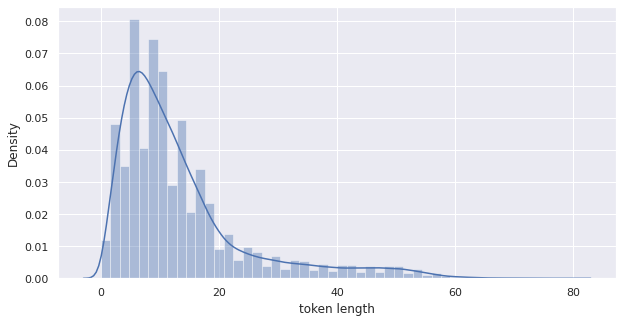

In [72]:
# 토큰 길이 분포 시각화
plt.figure(figsize=(10,5))
sns.set_theme();
sns.distplot(all_data_series)
plt.xlabel("token length")
plt.show()

In [74]:
# 단어들을 숫자로 변환한다.
X_train = encode_sentences(X_train, word_to_index)
X_test = encode_sentences(X_test, word_to_index)

# keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                       value=word_to_index["<PAD>"],
                                       padding='post',
                                       maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                       value=word_to_index["<PAD>"],
                                       padding='post',
                                       maxlen=maxlen)

print(X_train.shape)

(145194, 32)


# Modeling

Keras의 함수형 API를 이용하여 모델을 구성하였다.

네이버 영화리뷰 감성분석 관련 논문을 찾아봤는데 대체로 좋은 성능을 보여주는 네트워크는 

CNN, LSTM, BiLSTM, GRU 등을 결합한 네트워크로 보인다.
```
이번 과제에서는 다음의 layer를 연결하여 네트워크를 구성하였다.

Embedding
SpatialDropout1D, Dropout
GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate
Dense,Input,LSTM,Bidirectional,Conv1D,GRU
```

[Parallel Stacked Bidirectional LSTM 모델을 이용한 한국어 영화리뷰 감성 분석](https://www.kci.go.kr/kciportal/ci/sereArticleSearch/ciSereArtiView.kci?sereArticleSearchBean.artiId=ART002432654)

In [93]:
from keras.layers import Dropout,Embedding
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D
from keras.layers import Dense,Input,LSTM,Bidirectional,Conv1D,GRU

vocab_size = len(word_to_index)
word_vector_dim = 100

def build_model(vocab_size, word_vector_dim, maxlen, embeddings_initializer=None):
    
    inputs = Input(shape=(maxlen, ))
    x = Embedding(vocab_size, word_vector_dim, input_shape=(None,))(inputs)
    x = SpatialDropout1D(0.2)(x)
    x = Bidirectional(GRU(32, return_sequences=True,dropout=0.1,recurrent_dropout=0.1))(x)
    x = Conv1D(16, kernel_size = 3)(x)
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    x = concatenate([avg_pool, max_pool]) 
    x = Dense(8, activation='relu')(x)
    x = Dropout(0.1)(x)
    preds = Dense(1, activation="sigmoid")(x)
    
    return Model(inputs, preds)

model = build_model(vocab_size, word_vector_dim, 32)
model.compile(loss='binary_crossentropy',optimizer=Adam(lr=0.001),metrics=['accuracy'])

In [94]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           [(None, 32)]         0                                            
__________________________________________________________________________________________________
embedding_23 (Embedding)        (None, 32, 100)      1000000     input_24[0][0]                   
__________________________________________________________________________________________________
spatial_dropout1d_6 (SpatialDro (None, 32, 100)      0           embedding_23[0][0]               
__________________________________________________________________________________________________
bidirectional_19 (Bidirectional (None, 32, 64)       25728       spatial_dropout1d_6[0][0]        
____________________________________________________________________________________________

In [95]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.9, random_state=233)

print('X_train shape : {}, y_train shape : {} : ', X_train.shape, y_train.shape)
print('X_val shape : {}, y_val shape : {} ', X_val.shape, y_val.shape)
print('X_test shape : {}, y_test shape: {} ', X_test.shape, y_test.shape)

X_train shape : {}, y_train shape : {} :  (117606, 32) (117606,)
X_val shape : {}, y_val shape : {}  (13068, 32) (13068,)
X_test shape : {}, y_test shape: {}  (48748, 32) (48748,)


In [96]:
batch_size = 128
epochs = 4

model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_val, y_val),
          verbose=1
)

Epoch 1/10
919/919 [==============================] - 202s 204ms/step - loss: 0.4930 - accuracy: 0.7484 - val_loss: 0.3653 - val_accuracy: 0.8297
Epoch 2/10
919/919 [==============================] - 185s 201ms/step - loss: 0.3426 - accuracy: 0.8494 - val_loss: 0.3577 - val_accuracy: 0.8391
Epoch 3/10
919/919 [==============================] - 185s 201ms/step - loss: 0.3075 - accuracy: 0.8646 - val_loss: 0.3669 - val_accuracy: 0.8366
Epoch 4/10
919/919 [==============================] - 185s 202ms/step - loss: 0.2781 - accuracy: 0.8784 - val_loss: 0.3735 - val_accuracy: 0.8370
Epoch 5/10
919/919 [==============================] - 186s 202ms/step - loss: 0.2543 - accuracy: 0.8886 - val_loss: 0.3987 - val_accuracy: 0.8351
Epoch 6/10
919/919 [==============================] - 185s 201ms/step - loss: 0.2321 - accuracy: 0.8974 - val_loss: 0.4121 - val_accuracy: 0.8326
Epoch 7/10
919/919 [==============================] - 185s 202ms/step - loss: 0.2131 - accuracy: 0.9060 - val_loss: 0.4680 -

### Loss, Accuracy 그래프 시각화

In [97]:
history = model.history.history

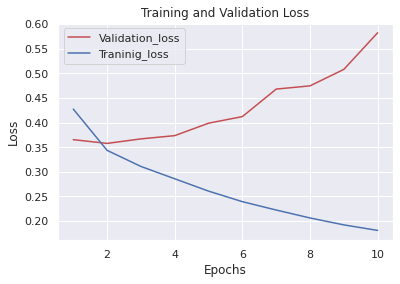

In [99]:
val_loss = history['val_loss']
loss = history['loss']
epochs = range(1, 5)

plt.plot(epochs, val_loss, 'r-', label='Validation_loss')
plt.plot(epochs, loss, 'b-', label='Traninig_loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

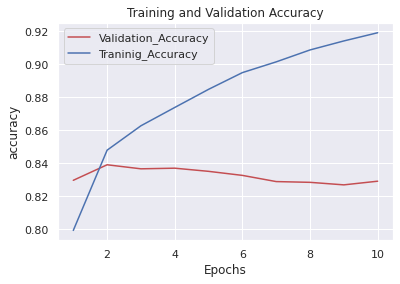

In [100]:
val_accuracy = history['val_accuracy']
accuracy = history['accuracy']
epochs = range(1, 5)

plt.plot(epochs, val_accuracy, 'r-', label='Validation_Accuracy')
plt.plot(epochs, accuracy, 'b-', label='Traninig_Accuracy')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [101]:
# 결과가 상당히 안좋다...
results = model.evaluate(X_test, y_test)

1524/1524 [==============================] - 25s 16ms/step - loss: 2.8840 - accuracy: 0.4996


### 내가 학습한 Embedding layer 레이어 분석

In [ ]:
# # model.layers의 가중치가 저장이 안되있는데 에러가 발생해서 확인을 하지 못했다.

# # 임베딩 레이어 차원 확인
# embedding_layer = model.layers[0]
# weights = embedding_layer.get_weights()[0]
# print(weights.shape)    # shape: (vocab_size, embedding_dim)

In [106]:
import os
# 학습한 Embedding 파라미터를 파일에 써서 저장
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.
index_to_word = khaii_index_to_word

# 단어 개수(특수문자 4개는 제외)만큼의 워드 벡터를 파일에 기록
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [109]:
from gensim.models.keyedvectors import Word2VecKeyedVectors
# 파일에 기록된 임베딩 파라미터를 읽어서 word vector로 활용
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

In [115]:
# 유사한 단어와 그 유사도 확인
word_vectors.similar_by_word("짱")[:10]

[('저장', 0.8486713171005249),
 ('굿', 0.8467870950698853),
 ('미술관', 0.844487726688385),
 ('먹먹', 0.8429173231124878),
 ('흠잡', 0.8415807485580444),
 ('재미남', 0.8381831049919128),
 ('개웃김', 0.8366275429725647),
 ('점때', 0.8358308672904968),
 ('정점', 0.8337755799293518),
 ('디카프리오', 0.8336794972419739)]

### Word2Vec을 활용한 성능 개선

In [136]:
!pip install --upgrade gensim==3.8.3

     |████████████████████████████████| 24.2 MB 5.4 MB/s eta 0:00:01
  Attempting uninstall: gensim
    Found existing installation: gensim 4.0.1
    Uninstalling gensim-4.0.1:
      Successfully uninstalled gensim-4.0.1
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [138]:
from gensim.models import Word2Vec

word2vec_path = os.getenv('HOME') + '/aiffel/sentiment_classification/data/ko.bin'
word2vec_pre = Word2Vec.load(word2vec_path)
word2vec_pre.wv.similar_by_word('짱')[:10]

ERROR:gensim.models.word2vec:Model load error. Was model saved using code from an older Gensim Version? Try loading older model using gensim-3.8.3, then re-saving, to restore compatibility with current code.


AttributeError: Can't get attribute 'Vocab' on <module 'gensim.models.word2vec' from '/opt/conda/lib/python3.7/site-packages/gensim/models/word2vec.py'>

In [ ]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000     # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩 차례대로 카피
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.9, random_state=233)

print('X_train shape : {}, y_train shape : {} : ', X_train.shape, y_train.shape)
print('X_val shape : {}, y_val shape : {} ', X_val.shape, y_val.shape)
print('X_test shape : {}, y_test shape: {} ', X_test.shape, y_test.shape)

In [ ]:
vocab_size = len(word_to_index)
word_vector_dim = 200
embeddings_initializer = Constant(embedding_matrix)

model = build_model(vocab_size, word_vector_dim, 32,embeddings_initializer )
model.compile(loss='binary_crossentropy',optimizer=Adam(lr=0.001),metrics=['accuracy'])
batch_size = 128
epochs = 3

model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_val, y_val),
          verbose=1
)

In [ ]:
history = model.history.history

In [ ]:
val_loss = history['val_loss']
loss = history['loss']
epochs = range(1, 4)

plt.plot(epochs, val_loss, 'r-', label='Validation_loss')
plt.plot(epochs, loss, 'b-', label='Traninig_loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
val_accuracy = history['val_accuracy']
accuracy = history['accuracy']
epochs = range(1, 4)

plt.plot(epochs, val_accuracy, 'r-', label='Validation_Accuracy')
plt.plot(epochs, accuracy, 'b-', label='Traninig_Accuracy')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [ ]:
results = model.evaluate(X_test, y_test)

## 결과 요약

1. 분석을 시작하기에 앞서 label 데이터의 분포를 확인하여 data augmentation의 필요성이 있는지 확인하였다.
2. 한국어 임베딩 책에 나오는 7가지 형태소 분석기를 사용해보았고 khaiii 형태소 분석기를 최종적으로 선택하였다.
3. token_length 분포에서 90% 상,하한 범위 내의 글자수를 가지는 텍스트를 분석에 사용하였다.
4. 모델링에서는 함수형 API를 사용하여 CNN, LSTM, GRU 등을 결합한 layer를 구성하였다.
5. 테스트 결과는 오버피팅이 심하게 발생하고 에폭을 줄여봐도 같은 현상이 발생하므로 분석 방법을 재검토할 필요성이 있다.
6. label의 noise가 존재하는 것 같다.
7. word2vec 임베딩을 추가해서 에폭을 적게하여 테스트했는데 유의미한 성능 개선이 있었다. 임베딩 벡터를 추가하면 